In [355]:
#data preprocessing
from sklearn.preprocessing import MinMaxScaler # for scaling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm
from scipy.stats import zscore

import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
keras = tf.keras

#models
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [356]:
path  = 'data/station_rio.csv'

In [357]:
df = pd.read_csv(path)
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [358]:
import pandas as pd

# Define the months dictionary
months_dict = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
               'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}

# Reorder columns based on months_dict
df = df[['YEAR'] + list(months_dict)]

# Melt the dataframe
# Melting is a data transformation that converts wide-format data with multiple columns into a long-format representation 
# with fewer columns by stacking the values vertically and 
# creating additional columns to store the original column names and corresponding values.
df = pd.melt(df, id_vars='YEAR', value_vars=list(months_dict.keys()), 
             var_name='MONTH', value_name='Sum of Value')

# Convert month names to month numbers
df['MONTH'] = df['MONTH'].map(months_dict)

# Create a datetime index
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(day=1))
df = df.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1).sort_index()

# Rename column
df = df.rename(columns={'Sum of Value': 'TEMP'})


In [359]:
df.head()

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1973-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


# DEALING WITH OUTLIERS

Text(0.5, 1.0, 'WITH OUTLIERS')

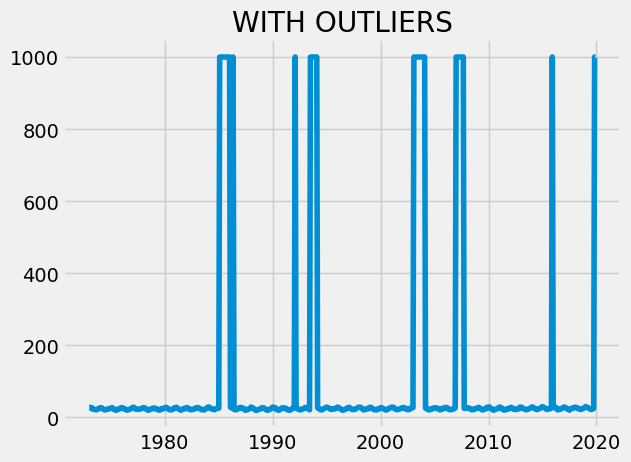

In [361]:
plt.plot(df)
plt.title('WITH OUTLIERS')

In [362]:
# Calculate the mean and standard deviation
mean_temp = df['TEMP'].mean()
std_temp = df['TEMP'].std()

In [363]:
# Set values that are further from the mean by more than 2 times the standard deviation
df.loc[abs(df['TEMP'] - mean_temp) > 2 * std_temp, 'TEMP'] = np.nan

Text(0.5, 1.0, 'WITHOUT OUTLIERS')

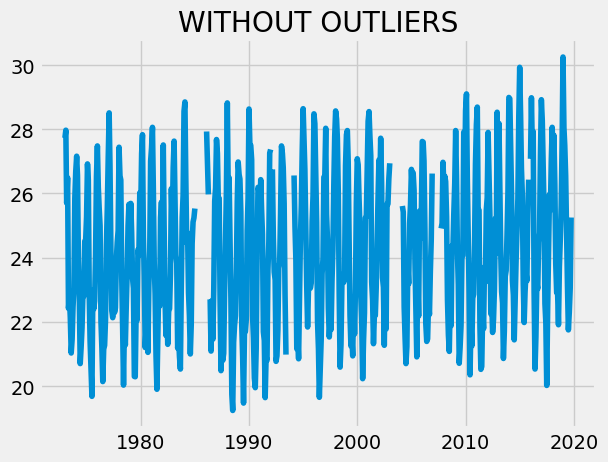

In [364]:
plt.plot(df)
plt.title('WITHOUT OUTLIERS')

In [365]:
df_interpolated = df.interpolate()

In [366]:
rows = 2
cols = 1

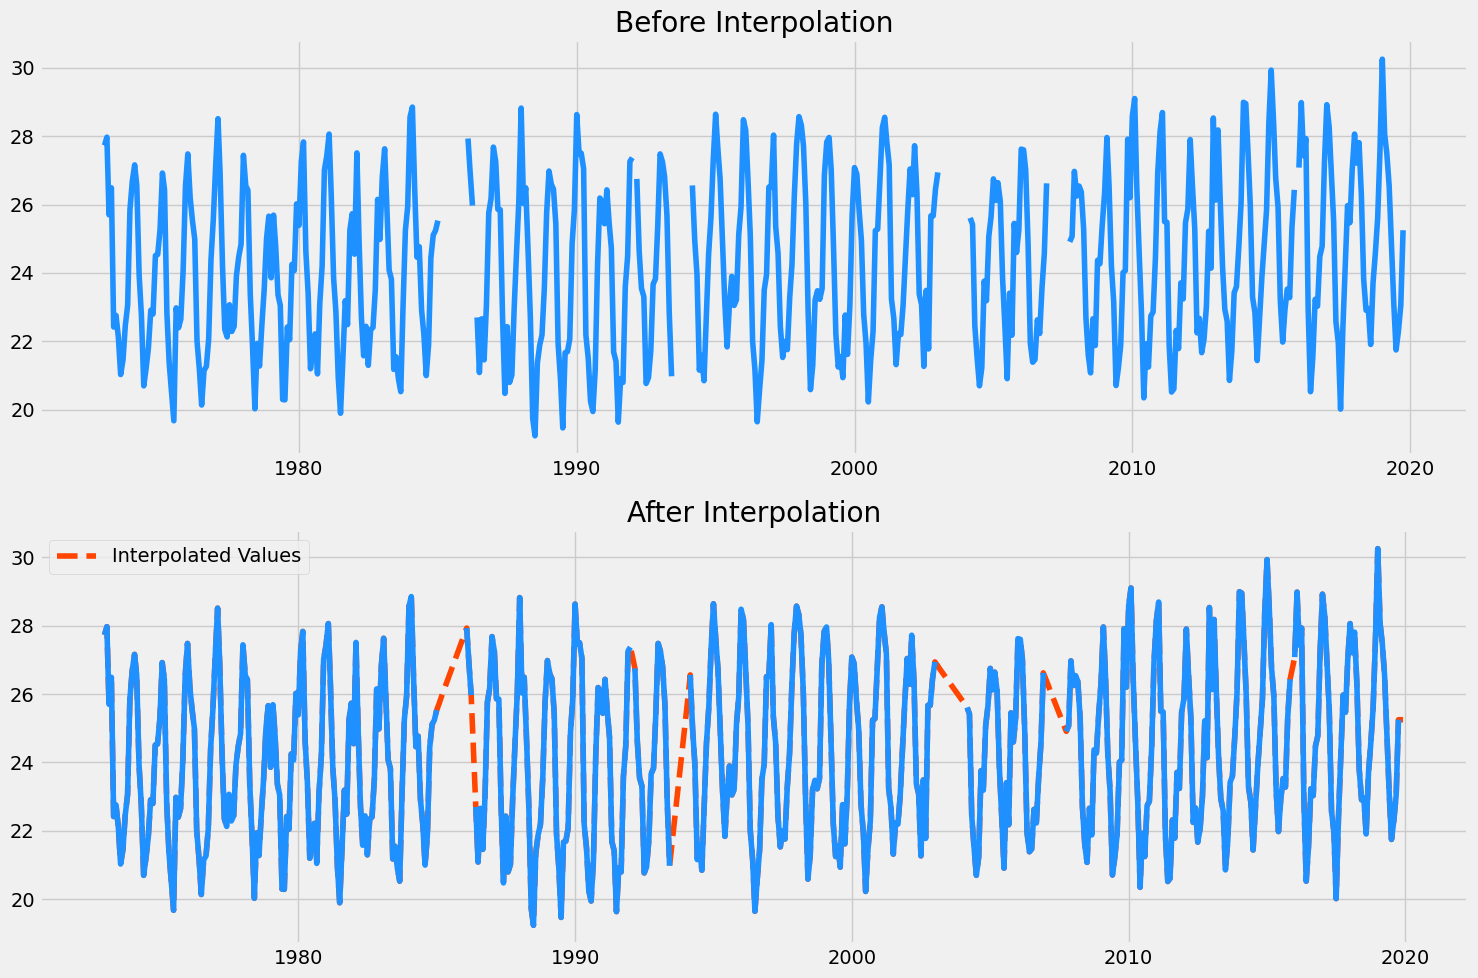

In [367]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
# Plotting the original data
axs[0].set_title('Before Interpolation')
axs[0].plot(df, color='dodgerblue')

# Plotting the interpolated data
axs[1].plot(df_interpolated, color='orangered', linestyle='--', label='Interpolated Values')
axs[1].set_title("After Interpolation")
axs[1].plot(df, color='dodgerblue')

# Adjusting the layout
plt.tight_layout()

# Adding a legend to the second subplot
legend = axs[1].legend(loc='upper left')

# Display the figure
plt.show()

In [368]:
df = df_interpolated

# Train and Test Data

In [369]:
# storing only values
temp = df.filter(["TEMP"])
temp_values = temp.values

# Using 95% of data for training
training_data_len = int(np.ceil(len(temp_values) * .94)) 

training_data_len

531

# SCALING

In [370]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(temp_values)

scaled_data[:10]

array([[0.77111717],
       [0.79291553],
       [0.58673933],
       [0.65849228],
       [0.28882834],
       [0.31970936],
       [0.26339691],
       [0.16257947],
       [0.20163488],
       [0.2924614 ]])

# SPLITTING

In [371]:
train_data = scaled_data[0:int(training_data_len), :]

#split the data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

print(f'x lenght: {len(x_train)}')
print(f'y lenght: {len(y_train)}')

#converting training and test do numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.77111717, 0.79291553, 0.58673933, 0.65849228, 0.28882834,
       0.31970936, 0.26339691, 0.16257947, 0.20163488, 0.2924614 ,
       0.34695731, 0.60036331, 0.67574932, 0.71934605, 0.66485014,
       0.42688465, 0.31970936, 0.13260672, 0.17801998, 0.23342416,
       0.33333333, 0.32334242, 0.47865577, 0.48138056, 0.54768392,
       0.69754768, 0.65304269, 0.32515895, 0.19346049, 0.11444142,
       0.03996367, 0.33969119, 0.28701181, 0.30971844, 0.44232516,
       0.66212534, 0.74841054, 0.63215259, 0.57311535, 0.5222525 ,
       0.25158946, 0.17620345, 0.08174387, 0.17347866, 0.18437784,
       0.25613079, 0.46866485, 0.57402361, 0.71662125, 0.84196185,
       0.69391462, 0.45231608, 0.28247048, 0.26248865, 0.34786558,
       0.27702089, 0.29064487, 0.42506812, 0.47593097, 0.50862852])]
[0.7447774750227065]

[array([0.77111717, 0.79291553, 0.58673933, 0.65849228, 0.28882834,
       0.31970936, 0.26339691, 0.16257947, 0.20163488, 0.2924614 ,
       0.34695731, 0.60036331, 0.675

# LSTM

In [372]:
# Building the LSTM network
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding a dropout layer for regularization
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))  # Adding another dropout layer
model.add(Dense(25, activation='relu'))  # Adding activation function to the dense layer
model.add(Dense(1))

In [373]:
#compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [374]:
#training the model
model.fit(x_train, y_train, batch_size = 1, epochs = 5, verbose=False)

# TEST

In [375]:
# Creating the testing dataset
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = temp_values[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Converting the data into a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted temperature values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

2/2 [==============================] - 1s 6ms/step
Root Mean Squared Error (RMSE): 1.06


# RESULTS

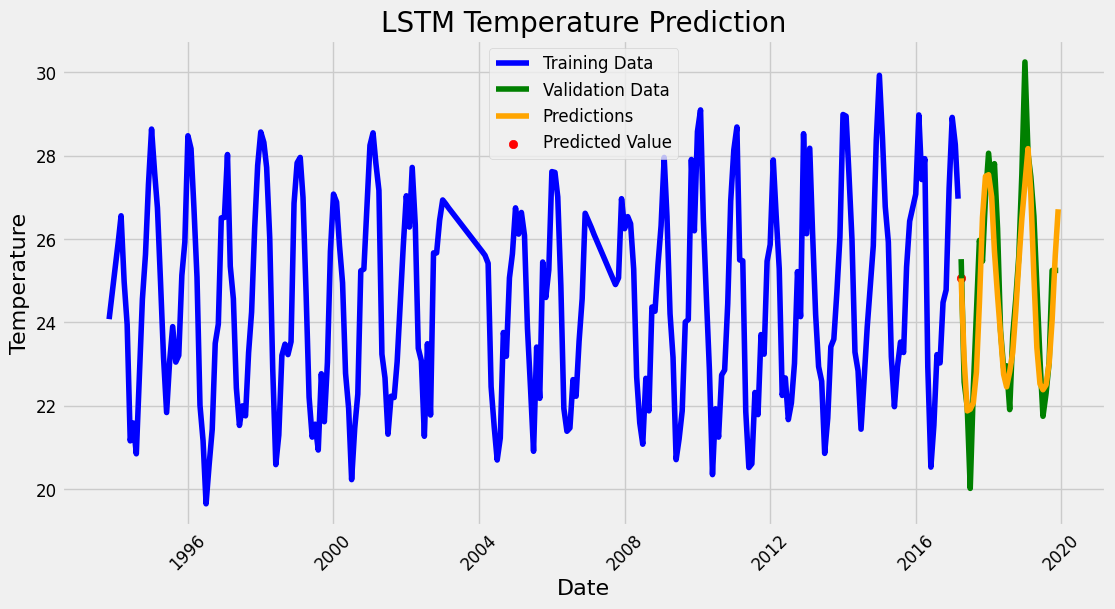

In [378]:
# Plotting the data
train = temp[250:training_data_len]
valid = temp[training_data_len:]
valid['Predictions'] = predictions

# Plotting the results
plt.figure(figsize=(12, 6))
plt.title('LSTM Temperature Prediction', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature', fontsize=16)

# Plotting the training data
plt.plot(train['TEMP'], label='Training Data', color='blue')

# Plotting the validation data and predictions
plt.plot(valid['TEMP'], label='Validation Data', color='green')
plt.plot(valid['Predictions'], label='Predictions', color='orange')

# Marking the prediction data point
last_training_date = train.index[-1]
prediction_date = valid.index[0]
prediction_value = valid['Predictions'][0]
plt.scatter(prediction_date, prediction_value, color='red', label='Predicted Value')

# Adding a legend and grid
plt.legend(fontsize=12)
plt.grid(True)

# Customizing tick labels for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.show()